## ML Project: Delayed Flights
A classification problem involving whether a flight will be delayed based on past data about:
- year of flight
- carrier
- airport
- distance
- time of departure
- and more!

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod

# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


## Step 1: Exploratory Data Analysis
The dataset I will be working on is the kaggle January Flight Delay dataset. I will perform the first step of the ML pipeline, EDA, on this dataset.

For reference, a link to a description of the dataset is linked here: [https://docs.google.com/document/d/1FP7WVHgmvOfypMkYMs-HZo1liRk3u3YqpVW4JHm8Bj8/edit?usp=sharing] , but can also be found as a txt file in the data folder of this project repository.

First, reading it in and creating easier columns:

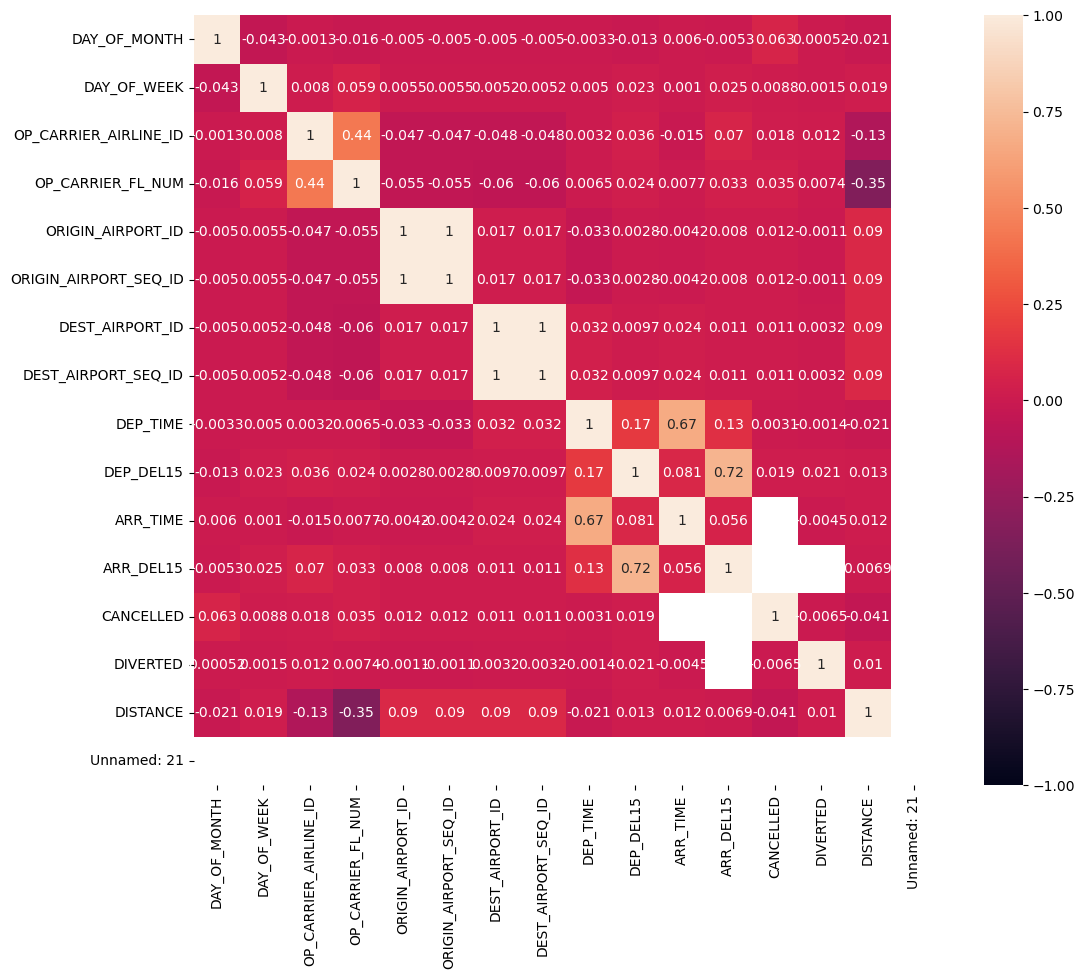

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
#Read files in:
df19 = pd.read_csv('data/archive/Jan_2019_ontime.csv')
df20 = pd.read_csv('data/archive/Jan_2020_ontime.csv')
temp_df_corr = pd.concat([df19, df20], ignore_index=True)

#Make columns easier:
df19 = df19.rename(columns={'DAY_OF_MONTH': 'DATE'})
df20 = df20.rename(columns={'DAY_OF_MONTH': 'DATE'})

df19['DATE'] = pd.to_datetime('2019-01-' + df19['DATE'].apply(str))
df20['DATE'] = pd.to_datetime('2020-01-' + df20['DATE'].apply(str))

df19['DAY_OF_WEEK']=df19['DATE'].dt.day_name()
df20['DAY_OF_WEEK']=df20['DATE'].dt.day_name()


df19.head(10)

#make pearson heat map with numeric data:
import seaborn as sns
# Select only numeric columns for correlation
numeric_cols = temp_df_corr.select_dtypes(include=[np.number])

# Create the correlation matrix
corr = numeric_cols.corr()

# Create a heatmap
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot = True, xticklabels=corr.columns.values, yticklabels=corr.columns.values,  vmin=-1, vmax=1)
plt.savefig('images/Pearson.png', dpi = 300)
plt.show()

Now that it's cleaner, I will perform non-visual EDA tasks:

In [3]:
print(df19.dtypes) 


DATE                     datetime64[ns]
DAY_OF_WEEK                      object
OP_UNIQUE_CARRIER                object
OP_CARRIER_AIRLINE_ID             int64
OP_CARRIER                       object
TAIL_NUM                         object
OP_CARRIER_FL_NUM                 int64
ORIGIN_AIRPORT_ID                 int64
ORIGIN_AIRPORT_SEQ_ID             int64
ORIGIN                           object
DEST_AIRPORT_ID                   int64
DEST_AIRPORT_SEQ_ID               int64
DEST                             object
DEP_TIME                        float64
DEP_DEL15                       float64
DEP_TIME_BLK                     object
ARR_TIME                        float64
ARR_DEL15                       float64
CANCELLED                       float64
DIVERTED                        float64
DISTANCE                        float64
Unnamed: 21                     float64
dtype: object


I've decided to concatenate both dataframes, because my strategy is to use group-based k-fold. Specifically, I will do group-based k-fold cross-validation and time-based splitting, meaning that I will group the data by airport and use 2019 and 2020 data for training and testing separately. 

In [4]:
flight_df = pd.concat([df19, df20], ignore_index=True)
flight_df.head()
#flight_df.tail()

,DATE,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,2019-01-01,Tuesday,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,2019-01-01,Tuesday,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,2019-01-01,Tuesday,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,2019-01-01,Tuesday,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,2019-01-01,Tuesday,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [5]:
flight_df.shape

(1191331, 22)

Now let's understand and visualize the key features

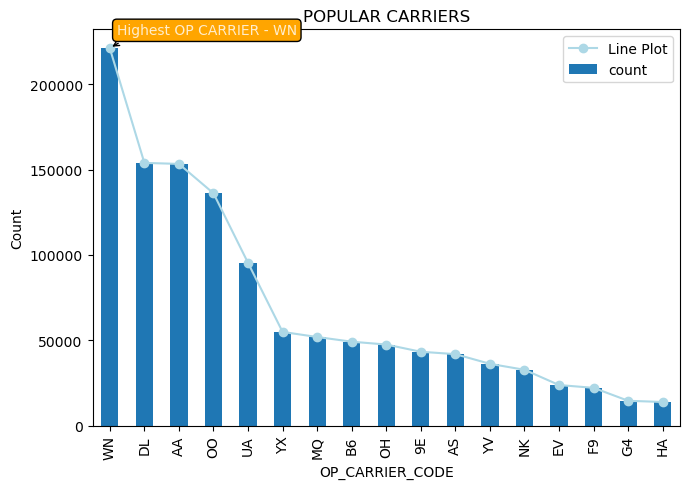

In [6]:
import matplotlib
from matplotlib import pylab as plt


#OP_CARRIER_19:
plt.figure(figsize=(7, 5))
flight_df['OP_CARRIER'] = flight_df['OP_CARRIER'].astype('category')

# Create a bar plot
carrier_counts = pd.value_counts(flight_df['OP_CARRIER'])
ax = carrier_counts.plot.bar()
plt.ylabel('Count')
plt.xlabel('OP_CARRIER_CODE')
plt.title('POPULAR CARRIERS')

# Add an annotation for the 'WN' bar
wn_count = carrier_counts['WN']
wn_index = carrier_counts.index.get_loc('WN')
plt.annotate("Highest OP CARRIER - WN", xy=(wn_index, wn_count), xytext=(5, 10),
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3,rad=.2"),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="orange"),
             fontsize=10, color="white", alpha=0.8)
plt.plot(carrier_counts.index, carrier_counts.values, marker='o', linestyle='-', color='lightblue', label='Line Plot')
plt.legend()

plt.tight_layout()
plt.savefig('images/PopularCarrier.png', dpi =300)
plt.show()




popular airports:

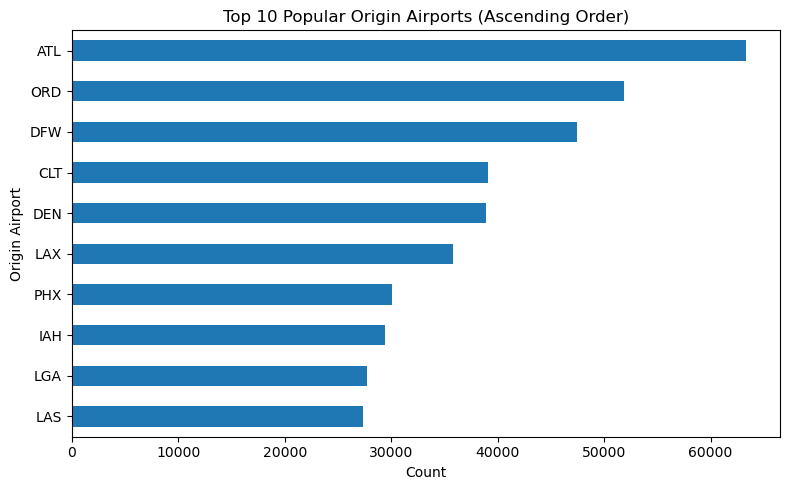

In [7]:

plt.figure(figsize=(8, 5))  

df_Org = flight_df['ORIGIN'].value_counts().head(10)

# Sort values in ascending order
df_Org = df_Org.sort_values(ascending=True)

# Create the horizontal bar chart
df_Org.plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Origin Airport')
plt.title('Top 10 Popular Origin Airports (Ascending Order)')
plt.tight_layout()
plt.show()

pie chart to visualize the distances of flights!:

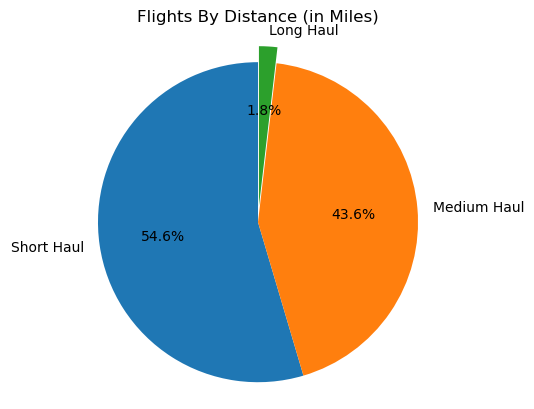

In [8]:

# Define the distance categories
short_haul = flight_df[(flight_df['DISTANCE'] < 700)].count()[0]
medium_haul = flight_df[(flight_df['DISTANCE'] >= 700) & (flight_df['DISTANCE'] <= 2500)].count()[0]
long_haul = flight_df[(flight_df['DISTANCE'] > 2500)].count()[0]

# Calculate the percentages
total_flights = len(flight_df)
short_haul_percentage = (short_haul / total_flights) * 100
medium_haul_percentage = (medium_haul / total_flights) * 100
long_haul_percentage = (long_haul / total_flights) * 100

# Mkae pie chart:
labels = ['Short Haul', 'Medium Haul', 'Long Haul']
sizes = [short_haul_percentage, medium_haul_percentage, long_haul_percentage]  # The sizes or percentages for each category


explode = (0, 0, 0.1)  # Explode the 1st slice (Short Haul)

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)

# Add a title
plt.title('Flights By Distance (in Miles)')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

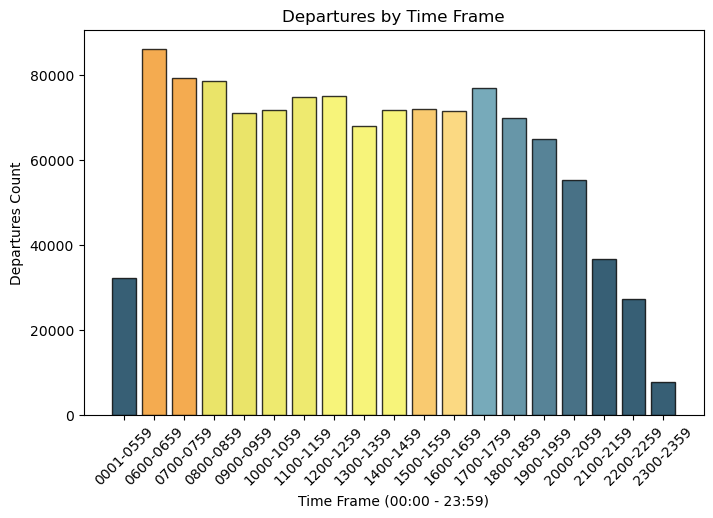

In [9]:
import matplotlib.pyplot as plt

df_time = pd.DataFrame(flight_df['DEP_TIME_BLK'].value_counts().reset_index().values, columns=["DEP_TIME_BLK", "AggregateDepTime"])

df_time = df_time.sort_values('DEP_TIME_BLK',ascending=True)

# Define colors
colors = ['#053752', '#f29624', '#f29624', '#e5de44', '#e5de44', '#eae54b', '#eae54b', '#f5f259', '#f5f259', '#f5f259',
          '#f8bd4c', '#fbd063', '#5595a9', '#417c93', '#2d647d', '#1a4d68', '#053752', '#053752', '#053752']

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(df_time['DEP_TIME_BLK'], df_time['AggregateDepTime'], color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Time Frame (00:00 - 23:59)')
plt.ylabel('Departures Count')
plt.title('Departures by Time Frame')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Highlight the "Highest Departures" with a text label


# Show the plot
plt.savefig('images/depblk.png', dpi = 300)
plt.show()


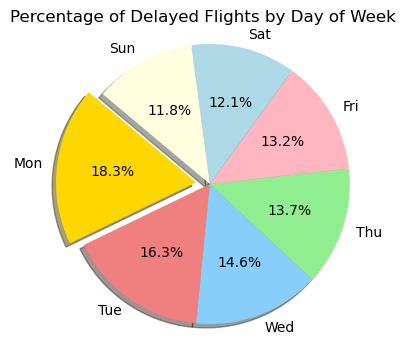

In [10]:
import matplotlib.pyplot as plt

# Your code for calculating the delayed flights by weekday and percentage
week = flight_df[['DAY_OF_WEEK', 'DEP_DEL15']].groupby('DAY_OF_WEEK').sum().sort_values(by='DEP_DEL15', ascending=False)
week['PERCENTUAL'] = week['DEP_DEL15'] / (week['DEP_DEL15'].sum()) * 100

# Create a pie chart
plt.figure(figsize=(4, 4))
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sizes = week['PERCENTUAL']
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'lightpink', 'lightblue', 'lightyellow']
explode = (0.1, 0, 0, 0, 0, 0, 0)  # Explode the first slice (e.g., 'Mon')

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

# Set a title
plt.title('Percentage of Delayed Flights by Day of Week')

# Display the plot
plt.axis('equal')  
plt.savefig('images/EDAdays.png', dpi = 300)
plt.show()



preprocess and split!:

In [11]:
flight_df.head()
#drop cols that will not be used:
flight_df = flight_df.drop(['OP_CARRIER', 'ORIGIN_AIRPORT_SEQ_ID', 'ARR_TIME', 'ARR_DEL15', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'Unnamed: 21', 'CANCELLED', 'DIVERTED'], axis=1)


## Step 2: Preprocess



In [12]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split

# Set a random seed for reproducibility
random_state = 42  

# Set up GroupKFold:
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

# Define the unique airports as groups
groups = flight_df['ORIGIN'].values

# Prepare features and target variable
y = flight_df['DEP_DEL15'] 
X = flight_df.loc[:, flight_df.columns != 'DEP_DEL15']
print('X shape:', X.shape)
print('y shape:', y.shape)

# I've decided not to use a 60-20-20 split, as this gets rather impossible for my objective of using 2020 as testing and 2019 as training/val.
# Instead, the ratios are more like 45-45-10. The slight difference in training and validation are due to the interaction between my desired 
#time based-splitting cuttoff of 2020 and the requirement that the same airport doesn't show up in testing and val in each fold.  

for train_idx, test_idx in group_kfold.split(X, y, groups):
    # Split the data into training and testing groups
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Time-based split within each group
    split_date = '2020-01-01'  
    train_mask = X_train['DATE'] < split_date
    test_mask = X_test['DATE'] >= split_date

    X_train, X_val = X_train[train_mask], X_train[~train_mask]
    y_train, y_val = y_train[train_mask], y_train[~train_mask]
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]

# Set random state
train_test_split(X, y, random_state=random_state)


    
print('X_test shape:', X_test.shape)
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)


X shape: (1191331, 11)
y shape: (1191331,)
X_test shape: (121741, 11)
X_train shape: (467461, 11)
X_val shape: (485605, 11)


Preprocessing: Missing Values

In [13]:
print('data dimensions:',flight_df.shape)
perc_missing_per_ftr = flight_df.isnull().sum(axis=0)/flight_df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(flight_df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(flight_df.isnull().sum(axis=1)!=0)/flight_df.shape[0]
print('fraction of points with missing values:',frac_missing)


data dimensions: (1191331, 12)
fraction of missing values in features:
TAIL_NUM     0.002720
DEP_TIME     0.019320
DEP_DEL15    0.019351
dtype: float64
data types of the features with missing values:
TAIL_NUM      object
DEP_TIME     float64
DEP_DEL15    float64
dtype: object
fraction of points with missing values: 0.019351464874161756


In [14]:
flight_df.columns

Index(['DATE', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID',
       'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'DISTANCE'],
      dtype='object')

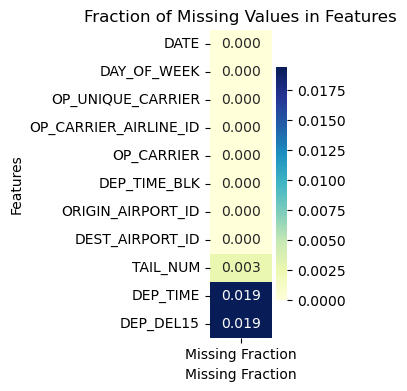

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fraction of missing values in features
missing_values_fraction = {
    'DATE': 0,
    'DAY_OF_WEEK': 0,
    'OP_UNIQUE_CARRIER': 0,
    'OP_CARRIER_AIRLINE_ID':0,
    'OP_CARRIER': 0,
    'DEP_TIME_BLK': 0,
    'ORIGIN_AIRPORT_ID': 0,
    'DEST_AIRPORT_ID': 0,
    'TAIL_NUM': 0.002720,
    'DEP_TIME': 0.019320,
    'DEP_DEL15': 0.019351
}

# Extracting feature names and missing value fractions
feature_names = list(missing_values_fraction.keys())
missing_fractions = list(missing_values_fraction.values())

# Creating a dataframe for heatmap
data = {
    'Features': feature_names,
    'Missing Fraction': missing_fractions
}
df = pd.DataFrame(data)

# Creating a one-column heatmap
plt.figure(figsize=(1, 4))
sns.heatmap(df[['Missing Fraction']], annot=True, fmt=".3f", cmap='YlGnBu', cbar=True)
plt.yticks(ticks=np.arange(len(feature_names)) + 0.5, labels=feature_names, rotation=0)
plt.title('Fraction of Missing Values in Features')
plt.xlabel('Missing Fraction')
plt.ylabel('Features')
plt.savefig('images/missingval.png', dpi = 300)
plt.show()

One hot encoder for preprocessing Tail Nums. 
Explanation of TAIL_NUM -> A tail number is an alphanumeric code between two and six characters in length used to identify a specific airplane. The alphabetical prefix of a tail number is indicative of an airplane's country of origin

In [16]:
len(flight_df['TAIL_NUM'].unique())

5858

In [17]:
#sanity check: actually checking that these columns are actually missing
rows_with_missing_values_tail = flight_df[flight_df['TAIL_NUM'].isna()]
rows_with_missing_values_tail.head()
#rows_with_missing_values_DEPDEL15 = flight_df[flight_df['DEP_DEL15'].isna()]
#rows_with_missing_values_DEPDEL15.head()

,DATE,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,DISTANCE
11084,2019-01-01,Tuesday,YV,20378,NaN,5975,FSD,DFW,NaN,NaN,0700-0759,737.0
17776,2019-01-01,Tuesday,YV,20378,NaN,5758,ABQ,PHX,NaN,NaN,0800-0859,328.0
53853,2019-01-03,Thursday,YX,20452,NaN,4629,OKC,PHL,NaN,NaN,0001-0559,1261.0
56065,2019-01-03,Thursday,YV,20378,NaN,5909,MOB,DFW,NaN,NaN,0600-0659,539.0
64336,2019-01-04,Friday,WN,19393,NaN,955,OKC,DCA,NaN,NaN,0700-0759,1158.0


In [18]:
df19.shape

(583985, 22)

## Step 3:  Cleanup from Midterm
Since the combined dataset contains 1 mill + points, I've decided to use 2019 data points as training and 2020 as validation, testing. This below code results in around 50-25-25 split.  


In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
flight_df.dropna(inplace=True)


# Separate data by year:
df_2019 = flight_df[flight_df['DATE'].dt.year == 2019]
df_2020 = flight_df[flight_df['DATE'].dt.year == 2020]

# Select features:
cat_ftrs = ['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME_BLK']
num_ftrs = ['DEP_TIME', 'DISTANCE']
target = 'DEP_DEL15'  

# Preprocessing:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_ftrs),
        ('num', numerical_transformer, num_ftrs)
    ])


X_2019 = df_2019[cat_ftrs + num_ftrs]
y_2019 = df_2019[target]
X_2020 = df_2020[cat_ftrs + num_ftrs]
y_2020 = df_2020[target]


X_2019_processed = preprocessor.fit_transform(X_2019)
X_2020_processed = preprocessor.transform(X_2020)

In [17]:

print(X_2020_processed.shape)

(600647, 6180)


In [20]:
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.model_selection import GroupKFold

#GroupKFold redux for 2020 based on origin airport:
groups_2020 = df_2020['ORIGIN'].values
group_kfold_2020 = GroupKFold(n_splits=5)

#Split 2020 for val and testing:
for train_index, test_index in group_kfold_2020.split(X_2020, y_2020, groups_2020):
    X_2020_train, X_2020_val_test = X_2020.iloc[train_index], X_2020.iloc[test_index]
    y_2020_train, y_2020_val_test = y_2020.iloc[train_index], y_2020.iloc[test_index]
    #break  
X_2020_val, X_2020_test, y_2020_val, y_2020_test = train_test_split(X_2020_processed, y_2020, test_size=0.5, random_state=42)

# Renaming for easier access in CV pipeline
X_train = X_2019_processed
y_train = y_2019
X_val = X_2020_val
y_val = y_2020_val
X_test = X_2020_test
y_test = y_2020_test
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

#keeping track of splits notes:
# X_2019_train), y_2019_train (Training outcome 2019)
# X_2020_validation, y_2020_validation (Validation 2020 data)
# X_2020_testing, y_2020_testing (Testing 2020 data)|


(567630, 6180) (567630,)
(300323, 6180) (300323,)
(300324, 6180) (300324,)


## Step 4: Implementing Algorithms and CV pipeline
I will first implement ML algos like log reg and random forest to get accuracy scores, then set up a cross-validation pipeline that makes it possible to implement multiple algos. 

In [20]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer



#Logistic Reg:
logistic_model = LogisticRegression(random_state=42, max_iter=10000)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('LogisticRegression', logistic_model)
])

#hyperparameters for GridSearchCV tuned!:
param_grid = {
    'LogisticRegression__C': [0.1, 1, 10]
}

#GridSearchCV for Logistic Regression:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_2019, y_2019)

#Evaluate best model on 2020 data:
best_logistic_model = grid_search.best_estimator_
best_logistic_model.fit(X_2019, y_2019)
y_pred = best_logistic_model.predict(X_2020)
accuracy = accuracy_score(y_2020, y_pred)
print(f"Accuracy on 2020 data: {accuracy}")

Accuracy on 2020 data: 0.8964916165401642


In [21]:
from sklearn.ensemble import RandomForestClassifier

#Rnadom Forest and pipeline set up:
rf_model = RandomForestClassifier(random_state=42)
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('RandomForest', rf_model)
])
#hyperparameters tuning:
param_grid_rf = {
    'RandomForest__n_estimators': [100, 200],
    'RandomForest__max_depth': [5, 10],
    #'regression__max_features': [3, 5, 7, None],
    #'RandomForest__max_depth': [1, 3, 5, 10, 20, None]
}

# GridSearchCV on rf:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_2019, y_2019)

# Evaluate best model on 2020:
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_2019, y_2019)
y_pred_rf = best_rf_model.predict(X_2020)
accuracy_rf = accuracy_score(y_2020, y_pred_rf)
print(f"Accuracy on 2020 data (Random Forest): {accuracy_rf}")


Accuracy on 2020 data (Random Forest): 0.8636736718904781


## Implementing Algos on split data
MLpipe_Kfold_RMSE function took too much RAM on my jupyter because of looping through the states. So, I implemented each algo individually, tuning each individually. Each algo is written individually instead of leveraging a function for easier organization and presentation, but is still a cv-pipeline as the same preprocessing and folds are implemeneted in the above and hyperparameters are tuned and cross validated

Linears:

In [22]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

def MLpipe_KFold_RMSE(X_train, y_train, X_val, y_val, X_test, y_test, ML_algo, param_grid):
    test_scores = []
    best_models = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    pipeline = Pipeline([
        ('model', ML_algo)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred_val = best_model.predict(X_val)
    rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
    test_scores.append(rmse_val)

    best_models.append(best_model)

    y_pred_test = best_model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

    return test_scores, best_models, rmse_test


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

from sklearn.metrics import make_scorer, accuracy_score, fbeta_score

#hyperparameters:
param_grid = {'C': [0.001, 0.1, 1, 10]}  

#Linear Support Vector Classifier (SVC) 
svm_linear_model = LinearSVC(random_state=42, max_iter=5000, dual=False)

#eval metrics:
scorer = {
    'accuracy': 'accuracy',
    'f_beta': make_scorer(fbeta_score, beta=2) 
}

#GridSearchCV
grid_search = GridSearchCV(estimator=svm_linear_model, param_grid=param_grid, cv=5, scoring=scorer, refit='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

#best params by gridsearch
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

#best model
best_svm_linear_model = grid_search.best_estimator_

#predict on test
y_pred_test = best_svm_linear_model.predict(X_test)

#accuracy for test
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy (Best Linear SVM):", accuracy_test)

# f_beta
f_beta_test = fbeta_score(y_test, y_pred_test, beta=2)  
print("Test F-beta Score (Best Linear SVM):", f_beta_test)

Best Parameters: {'C': 0.1}
Test Accuracy (Best Linear SVM): 0.8669037439565269
Test F-beta Score (Best Linear SVM): 0.04754970968696944


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#hyperparams
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

#LogReg
logistic_regression_model = LogisticRegression(max_iter=10000)

#eval metrics
scorer = {
    'accuracy': 'accuracy',
    'f_beta': make_scorer(fbeta_score, beta=2) 
}

#GridSearchCV
grid_search = GridSearchCV(estimator=logistic_regression_model, param_grid=param_grid, cv=5, scoring=scorer, refit='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

#best params by grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

#best model from grid search
best_logistic_regression_model = grid_search.best_estimator_

#predict on test
y_pred_test = best_logistic_regression_model.predict(X_test)

#accuracy on test
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy (Best Logistic Regression):", accuracy_test)

#f beta on test
f_beta_test = fbeta_score(y_test, y_pred_test, beta=2) 
print("Test F-beta Score (Best Logistic Regression):", f_beta_test)

Best Parameters: {'C': 100}
Test Accuracy (Best Logistic Regression): 0.8965317457146282
Test F-beta Score (Best Logistic Regression): 0.3044938740708102


## Now time for nonlinears!

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

#Gradient Boosting! #https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=42) 

#fit on training:
gradient_boosting_model.fit(X_train, y_train)

#predict on val:
y_pred_val = gradient_boosting_model.predict(X_val)

#calculate accuracy on val"
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy (Gradient Boosting):", accuracy_val)

#same on tesst: predict on test:
y_pred_test = gradient_boosting_model.predict(X_test)

#accuracy on test:
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy (Gradient Boosting):", accuracy_test)

Validation Accuracy (Gradient Boosting): 0.9086183875360861
Test Accuracy (Gradient Boosting): 0.9094411369054755


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

#RF
random_forest_model = RandomForestClassifier(n_estimators=10, max_features='sqrt', max_depth=10, random_state=42)

#Tuned hyperparameters
param_dist = {
    'max_depth': [3, 6, 9, None],
    'max_features': ['sqrt', 'log2', None]
}

#CV
random_search = RandomizedSearchCV(estimator=random_forest_model, param_distributions=param_dist,
                                   n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

#best params
best_params = random_search.best_params_
print("Best Parameters:", best_params)

#best rf model
best_random_forest_model = random_search.best_estimator_

#predict on val
y_pred_val = best_random_forest_model.predict(X_val)

#accuracy on val
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy (Best Random Forest Model):", accuracy_val)

#predict on test
y_pred_test = best_random_forest_model.predict(X_test)

#accuracy on test
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy (Best Random Forest Model):", accuracy_test)

# f beta on test
f_beta_test = fbeta_score(y_test, y_pred_test, beta=2)  
print("Test F-beta Score (Best Random Forest Model):", f_beta_test)

Best Parameters: {'max_features': None, 'max_depth': 9}
Validation Accuracy (Best Random Forest Model): 0.9117683294319783
Test Accuracy (Best Random Forest Model): 0.9128641067646941
Test F-beta Score (Best Random Forest Model): 0.44509179032632873


In [22]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score

#XGBOOST
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

#hyperparameters tuned
param_dist = {
    'max_depth': [3, 6],
    'reg_alpha': [0, 0.1, 0.5, 1.0]
}

#random search CV to save RAM
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

#best params
best_params = random_search.best_params_
print("Best Parameters:", best_params)

#best model
best_xgb_model = random_search.best_estimator_

#predictions on test
y_pred_test = best_xgb_model.predict(X_test)

#accuracy on test
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy (Best XGBoost Model):", accuracy_test)

# f beta on test
f_beta_test = fbeta_score(y_test, y_pred_test, beta=2)  
print("Test F-beta Score (Best XGBoost Model):", f_beta_test)

Best Parameters: {'reg_alpha': 1.0, 'max_depth': 6}
Test Accuracy (Best XGBoost Model): 0.9412068299569798
Test F-beta Score (Best XGBoost Model): 0.6736617528924498


## Results Section


In [23]:
#What is my baseline? 
#naive baseline binary implementation:

#majority class:
majority_class = y_test.value_counts().idxmax()

#array of baseline predictions w same lenght as y_test:
baseline_predictions = [majority_class] * len(y_test)

#baseline accuracy:
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print("Baseline Accuracy Score:", baseline_accuracy)

Baseline Accuracy Score: 0.8641567107523874


## Graphics: Mean and Standard Dev of Accuracies

In [80]:
#XGBOOST:
test_accuracies = []

for model in random_search.cv_results_['params']:
    xgb_model.set_params(**model)  
    xgb_model.fit(X_train, y_train)  
    y_pred_test = xgb_model.predict(X_test)  
    accuracy_test = accuracy_score(y_test, y_pred_test) 
    test_accuracies.append(accuracy_test)  
    print(f"Test Accuracy for model {model}: {accuracy_test}")

# Calculate mean and standard deviation of test accuracies
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)


print("\nMean Test Accuracy:", mean_accuracy)
print("Standard Deviation of Test Accuracies:", std_accuracy)

Test Accuracy for model {'reg_alpha': 0.1, 'max_depth': 3}: 0.9397350861070044
Test Accuracy for model {'reg_alpha': 0.1, 'max_depth': 6}: 0.9410070457239514
Test Accuracy for model {'reg_alpha': 0, 'max_depth': 3}: 0.9393754744875534
Test Accuracy for model {'reg_alpha': 1.0, 'max_depth': 6}: 0.9412068299569798
Test Accuracy for model {'reg_alpha': 0.5, 'max_depth': 3}: 0.9399681677122042

Mean Test Accuracy: 0.9402585207975387
Standard Deviation of Test Accuracies: 0.0007207828247589846


In [30]:
#RF:
test_accuracies = []

for model in random_search.cv_results_['params']:
    random_forest_model.set_params(**model)  
    random_forest_model.fit(X_train, y_train) 
    y_pred_test = random_forest_model.predict(X_test) 
    accuracy_test = accuracy_score(y_test, y_pred_test)  
    test_accuracies.append(accuracy_test)  
    print(f"Test Accuracy for model {model}: {accuracy_test}")

# Calculate mean and standard deviation of test accuracies
mean_accuracy_RF = np.mean(test_accuracies)
std_accuracy_RF = np.std(test_accuracies)

print("\nMean Test Accuracy:", mean_accuracy_RF)
print("Standard Deviation of Test Accuracies:", std_accuracy_RF)

Test Accuracy for model {'max_features': 'log2', 'max_depth': None}: 0.8763835058137212
Test Accuracy for model {'max_features': 'sqrt', 'max_depth': None}: 0.9057384691200171
Test Accuracy for model {'max_features': 'sqrt', 'max_depth': 3}: 0.8641567107523874
Test Accuracy for model {'max_features': None, 'max_depth': 9}: 0.9128641067646941
Test Accuracy for model {'max_features': None, 'max_depth': 6}: 0.8824869141327366

Mean Test Accuracy: 0.8883259413167114
Standard Deviation of Test Accuracies: 0.018254782377904132


In [84]:
#LogReg:
test_accuracies = []

#grid searhc cv
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

for params in param_grid['C']:
    logistic_regression_model.set_params(C=params)
    logistic_regression_model.fit(X_train, y_train)
    
    y_pred_test = logistic_regression_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    test_accuracies.append(accuracy_test)
    print(f"Test Accuracy (C={params}): {accuracy_test}")

mean_accuracy = sum(test_accuracies) / len(test_accuracies)
std_dev_accuracy = (sum((x - mean_accuracy) ** 2 for x in test_accuracies) / len(test_accuracies)) ** 0.5

print("\nMean Test Accuracy:", mean_accuracy)
print("Standard Deviation of Test Accuracies:", std_dev_accuracy)

Test Accuracy (C=0.01): 0.8738662244775642
Test Accuracy (C=0.1): 0.891706956486994
Test Accuracy (C=1): 0.8968181031153022
Test Accuracy (C=10): 0.8966649352033138
Test Accuracy (C=100): 0.8965317457146282

Mean Test Accuracy: 0.8911175929995604
Standard Deviation of Test Accuracies: 0.008837861007385607


In [82]:
#SVC:
# Linear SVM:
test_accuracies_SVM = []

for model in grid_search.cv_results_['params']:
    svm_linear_model.set_params(**model)
    svm_linear_model.fit(X_train, y_train)
    y_pred_test = svm_linear_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    test_accuracies_SVM.append(accuracy_test)
    print(f"Test Accuracy for model {model}: {accuracy_test}")

mean_accuracy_SVM = np.mean(test_accuracies_SVM)
std_accuracy_SVM = np.std(test_accuracies_SVM)

print("\nMean Test Accuracy (Linear SVM):", mean_accuracy_SVM)
print("Standard Deviation of Test Accuracies (Linear SVM):", std_accuracy_SVM)

Test Accuracy for model {'C': 0.01}: 0.8670768902918181
Test Accuracy for model {'C': 0.1}: 0.8669037439565269
Test Accuracy for model {'C': 1}: 0.8660346825428538
Test Accuracy for model {'C': 10}: 0.8658715254192139
Test Accuracy for model {'C': 100}: 0.8658781848936482

Mean Test Accuracy (Linear SVM): 0.8663530054208121
Standard Deviation of Test Accuracies (Linear SVM): 0.0005264844196706323


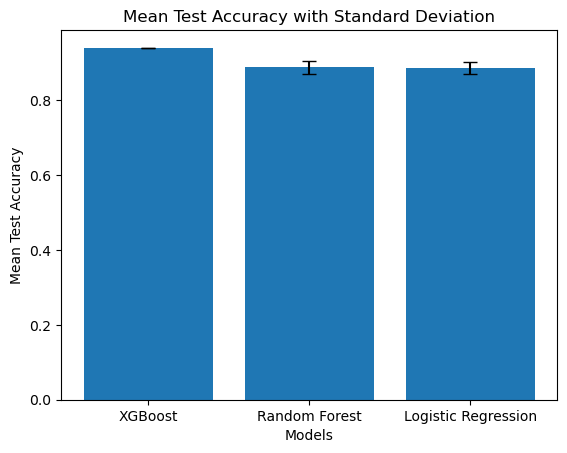

In [42]:
import matplotlib.pyplot as plt

# Mean test accuracies and standard deviations for each model
models = ['XGBoost', 'Random Forest', 'Logistic Regression']
mean_accuracies = [0.9402585207975387, 0.8883259413167114, 0.8861485151591837]
std_devs = [0.0007207828247589846, 0.018254782377904132, 0.015543961178898018]

# Create bar graph
fig, ax = plt.subplots()
ax.bar(models, mean_accuracies, yerr=std_devs, capsize=5)

# Set labels and title
ax.set_ylabel('Mean Test Accuracy')
ax.set_xlabel('Models')
ax.set_title('Mean Test Accuracy with Standard Deviation')

# Show the plot
plt.savefig('images/mean_sds1.png',dpi=300)
plt.show()


## Graphics Part 2: Confusion Matrices


In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred_test = model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred_test, normalize='true')

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'images/{model_name}_confusion_matrix.png', dpi = 300)
    plt.close()
    

In [105]:
#LogReg:
plot_confusion_matrix(best_logistic_regression_model, X_test, y_test, 'Logistic Regression')


In [106]:
#RF
plot_confusion_matrix(best_random_forest_model, X_test, y_test, 'Random Forest')



In [109]:
plot_confusion_matrix(best_svm_linear_model, X_test, y_test, 'Linear model')


In [108]:
#XGBOOST
plot_confusion_matrix(best_xgb_model, X_test, y_test, 'XGBoost')


## Global Feature Importance: Feature Importances


In [23]:
feature_names = preprocessor.get_feature_names_out(input_features=cat_ftrs + num_ftrs)

feature_names_list = feature_names.tolist()

#print(feature_names_list)

feature_mapping = {f'f{index}': name for index, name in enumerate(feature_names_list)}

#eg mapping for 'f6173' and 'f6162'
mapped_names = [feature_mapping['f6173'], feature_mapping['f6162']]
print(mapped_names)


['cat__DEP_TIME_BLK_1900-1959', 'cat__DEP_TIME_BLK_0800-0859']


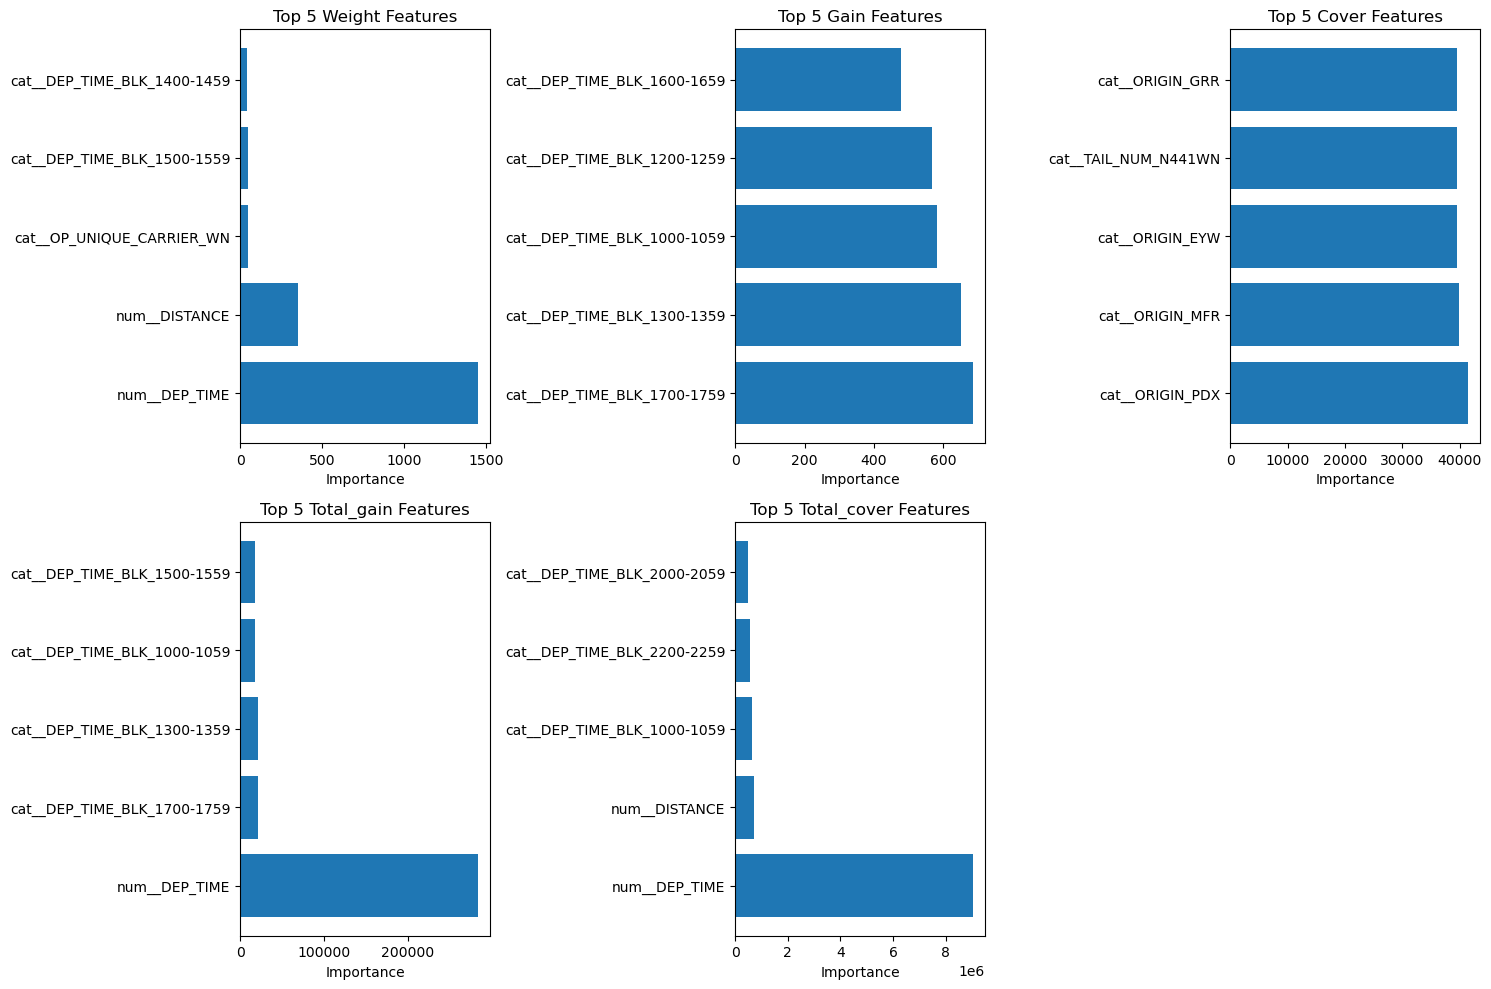

In [61]:
# your code here
#calculate 5 metrics:
feature_importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
feature_importances = [best_xgb_model.get_booster().get_score(importance_type=imp_type) for imp_type in feature_importance_types]
#plot 5 figures:
plt.figure(figsize=(15, 10))

for i, importance_type in enumerate(feature_importance_types):
    importance_dict = feature_importances[i]
    sorted_features = sorted(importance_dict, key=importance_dict.get, reverse=True)[:5]
    top_features = [importance_dict[feature] for feature in sorted_features]

    mapped_feature_names = [feature_mapping.get(feature, 'Unknown') for feature in sorted_features]

    
    plt.subplot(2, 3, i + 1)
    plt.barh(range(5), top_features, align='center')
    plt.yticks(range(5), mapped_feature_names)
    plt.xlabel('Importance')
    plt.title(f'Top 5 {importance_type.capitalize()} Features')

plt.tight_layout()
plt.savefig('images/global_importances.png', dpi =300)
plt.show()


In [25]:
import shap
shap.initjs()
#X_sample selects the actual datapoint
X_sample = X_test.getrow(15)
X_test_dense = X_test.toarray()
explainer = shap.Explainer(best_random_forest_model, X_test_dense)
X_sample = X_test_dense[0]

shap_values = explainer.shap_values(X_sample)

#force plot
i = 0
feature_names = feature_mapping
plt.savefig('images/shapplot.png', dpi = 300)
shap.force_plot(explainer.expected_value[i], shap_values[i], X_sample, feature_names=list(feature_mapping.values()))



<Figure size 640x480 with 0 Axes>